<a href="https://colab.research.google.com/github/hamedmirsadeghi/time_series/blob/main/STUMPY_Pattern_Searching_fx_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Pattern Searching

## Beyond Matrix Profiles

At the core of STUMPY, one can take any time series data and efficiently compute something called a [matrix profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html), which essentially scans along your entire times series with a fixed window size, `m`, and finds the exact nearest neighbor for every subsequence within your time series. A matrix profile allows you to determine if there are any conserved behaviors (i.e., conserved subsequences/patterns) within your data and, if so, it can tell you exactly where they are located within your time series. In a [previous tutorial](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html), we demonstrated how to use STUMPY to easily obtain a matrix profile, learned how to interpret the results, and discover meaningful motifs and discords. While this brute-force approach may be very useful when you don't know what pattern or conserved behavior you are looking but, for sufficiently large datasets, it can become quite expensive to perform this exhaustive pairwise search. 

However, if you already have a specific user defined pattern in mind then you don't actually need to compute the full matrix profile! For example, maybe you've identified an interesting trading strategy based on historical stock market data and you'd like to see if that specific pattern may have been observed in the past within one or more stock ticker symbols. In that case, searching for a known pattern or "query" is actually quite straightforward and can be accomplished quickly by using the wonderful `core.mass` function in STUMPY.

In this short tutorial, we'll take a simple known pattern of interest (i.e., a query subsequence) and we'll search for this pattern in a separate independent time series. Let's get started!

## Getting Started

Let's import the packages that we'll need to load, analyze, and plot the data

In [1]:
%%capture
!pip install scipy>=1.5
!pip install stumpy


In [265]:
%matplotlib inline
import os
import pandas as pd
import stumpy
import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.rcParams["figure.figsize"] = [10, 3]  # width, height
plt.rcParams['xtick.direction'] = 'out'

## The Datasets
Here it is assumed that we have a time-series that we want to predict its future
and we have several other time series that are used to find similarities to help
us predict our target time series.
The plan is to select a part of target time series as the query and try to find 
the most similar time series out of the other data to help us in prediction the future of the query.

In [432]:
ref_directory = '/content/reference_db/'
ref_list = [ref_directory + path for path in os.listdir(ref_directory) if ".csv" in path ]
print(ref_list)
target_TS_path = '/content/NZDUSD_M10_202106010000_202106232050.csv'

['/content/reference_db/EURCHF_M30_201305130130_202012312030.csv', '/content/reference_db/USDCAD_H4_201001040000_202012312000.csv', '/content/reference_db/EURGBP_M30_201305290600_202012312030.csv', '/content/reference_db/NZDCAD_H1_201801020000_202106221500.csv', '/content/reference_db/EURNZD_M15_201801020000_202106221530.csv', '/content/reference_db/GBPAUD_M15_201706140315_202012312045.csv', '/content/reference_db/EURJPY_M30_201304221000_202012312030.csv', '/content/reference_db/AUDUSD_M5_202002200130_202012312055.csv', '/content/reference_db/GBPUSD_M30_201304191030_202012312030.csv', '/content/reference_db/AUDCAD_H4_201001040000_202012312000.csv', '/content/reference_db/AUDUSD_M30_201304220030_202012312030.csv', '/content/reference_db/EURUSD_M15_201705300830_202012312045.csv', '/content/reference_db/AUDUSD_H4_201001040000_202012312000.csv', '/content/reference_db/EURGBP_H1_201001040000_202012312000.csv', '/content/reference_db/AUDUSD_H1_201001040000_202012312000.csv', '/content/refere

In [433]:
T_df = pd.read_csv(target_TS_path , sep='\t' )
T_df.head()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
0,2021.06.01,00:00:00,0.72644,0.72674,0.72558,0.72598,23,0,58
1,2021.06.01,00:10:00,0.72597,0.72773,0.72584,0.72744,61,0,14
2,2021.06.01,00:20:00,0.72744,0.72773,0.72558,0.72669,65,0,15
3,2021.06.01,00:30:00,0.72667,0.72743,0.72667,0.72708,23,0,23
4,2021.06.01,00:40:00,0.72708,0.72753,0.72708,0.72718,21,0,23


## Multivariate Time Series:
Does that motif exist in one, two, or all dimensions?

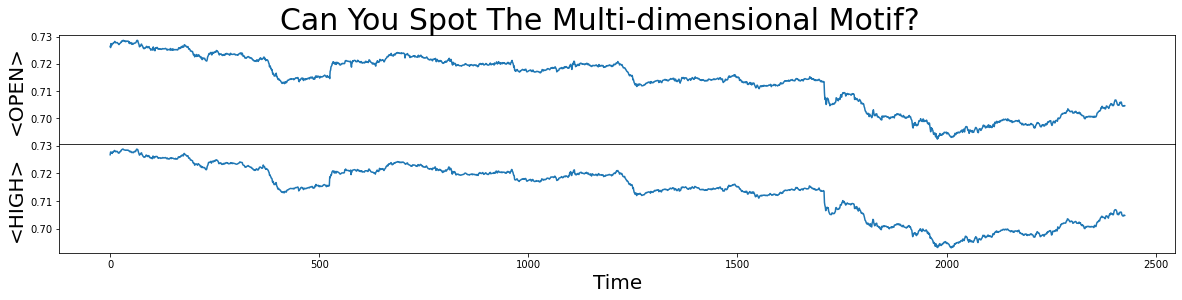

In [361]:
col_to_plot= T_df.columns[2:4]
fig, axs = plt.subplots(len(col_to_plot), sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Can You Spot The Multi-dimensional Motif?', fontsize='30')

for i,col in enumerate(col_to_plot):
    axs[i].set_ylabel(f'{col}', fontsize='20')
    axs[i].set_xlabel('Time', fontsize ='20')
    axs[i].plot(T_df[col])

plt.show()

## A Quick 1-Dimensional Exploration
Before diving into a multi-dimensional matrix profile analysis, let’s take a naive approach and simply run the classic 1-dimensional motif discovery algorithm, stumpy.stump, on each of the dimensions independently (using a window size of m = 1000) and extract 1-dimensional motif pairs:

## Visualizing the target Dataset

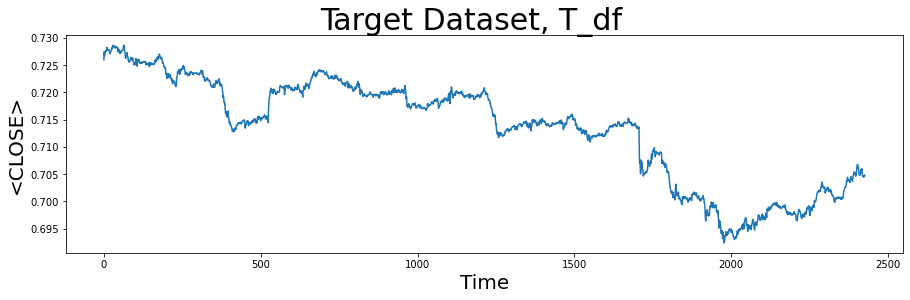

In [362]:
plt.rcParams["figure.figsize"] = [15, 4]  # width, height
plt.rcParams['xtick.direction'] = 'out'
col_name = '<CLOSE>'
plt.suptitle('Target Dataset, T_df', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel(col_name, fontsize='20')
plt.plot(T_df[col_name])
#plt.text(2000, 4.5, 'Cement', color="black", fontsize=20)
#plt.text(10000, 4.5, 'Cement', color="black", fontsize=20)
ax = plt.gca()
#rect = Rectangle((5000, -4), 3000, 10, facecolor='lightgrey')
#ax.add_patch(rect)
#plt.text(6000, 4.5, 'Carpet', color="black", fontsize=20)
plt.show()

## Have You Seen This Pattern?

The subsequence pattern or query (below) that we are interested in searching for in the time series (above) looks like this:

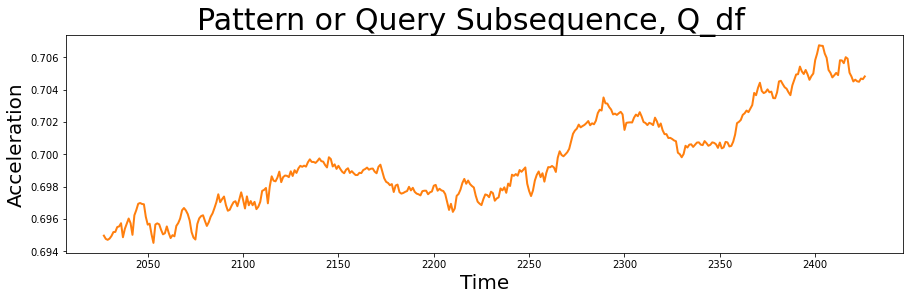

In [363]:
window = 400
start_idx = len(T_df) - window
Q_df = T_df.iloc[start_idx:(start_idx+window), :]

plt.suptitle('Pattern or Query Subsequence, Q_df', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Acceleration', fontsize='20')
plt.plot(Q_df[col_name], lw=2, color="C1")  
plt.show()

This pattern, `Q_df`, has a window length of `m = 2000`.

We can compare this specific query subsequence or pattern with other time series in the reference folder by computing something called a "distance profile". Essentially, you take this single query, `Q_df`, and compare it to every single subsequence in `ref_df` by computing all possible (z-normalized Euclidean) pairwise distances. So, the distance profile is simply a 1-dimensional vector that tells you exactly how similar/dissimilar `Q_df` is to every subsequence (of the same length) found in `ref_df`. 

## Computing the Distance Profile with MASS

So, given a query subsequence, `Q_df`, and a time series, `ref_df`, we can perform a fast similarity search and compute a distance profile using the `core.mass` function in STUMPY:

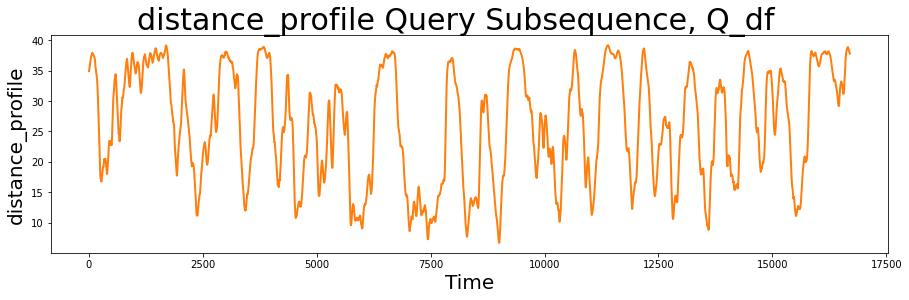

In [364]:
def compute_distance_profile(Q_df, ref_df, column, plot=True):
    distance_profile = stumpy.core.mass(Q_df[column], ref_df[column] )
    if plot:
        plt.suptitle('distance_profile Query Subsequence, Q_df', fontsize='30')
        plt.xlabel('Time', fontsize ='20')
        plt.ylabel('distance_profile', fontsize='20')
        plt.plot(distance_profile, lw=2, color="C1")
        plt.show()
    return distance_profile

ref_df = pd.read_csv(ref_list[1] , sep='\t' )
#ref_df = combine_features(ref_df, col_to_plot)
distance_profile = compute_distance_profile(Q_df, ref_df, col_name)

And, since the `distance_profile` contains the full list of pairwise distances between `Q_df` and every subsequence within `ref_df`, we can retrieve the most similar subsequence from `ref_df` by finding the smallest distance value in `distance_profile` and extracting its positional index:

In [365]:
idx = np.argmin(distance_profile)

print(f"The nearest neighbor to `Q_df` is located at index {idx} in `ref_df`")

The nearest neighbor to `Q_df` is located at index 9004 in `ref_df`


So, to answer our earlier question of "Does a similar pattern exist in our earlier time series, ref_df?", let's go ahead and plot the most similar subsequence in `ref_df`, which is located at index 67548  (blue), and overlay this with our query pattern, `Q_df`, (orange):

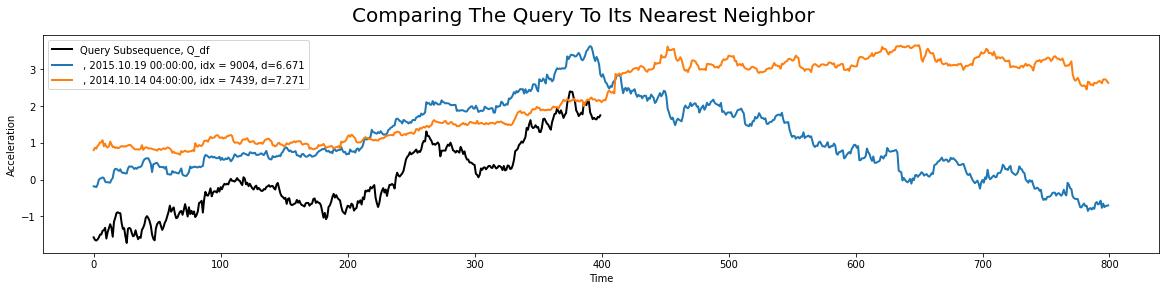

In [366]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting

def compare_query_NN(Q_df, ref_df, column, start_idx, y_offset = 0, future_horizon= 1.5, ref_name = ""):
    plt.suptitle('Comparing The Query To Its Nearest Neighbor', fontsize='20')
    plt.xlabel('Time', fontsize ='10')
    plt.ylabel('Acceleration', fontsize='10')
    
    Q_z_norm = stumpy.core.z_norm(Q_df[column].values)
    plt.plot(Q_z_norm, lw=2, color="k", label="Query Subsequence, Q_df")
    for n,i in enumerate(start_idx):
        horizon_idx = i + int(future_horizon * len(Q_df))
        ref_z_norm = (n+1)*y_offset + stumpy.core.z_norm(ref_df[column].values[i:horizon_idx])
        plt.plot(ref_z_norm, lw=2, label=f'{ref_name} , {" ".join(ref_df.loc[i,["<DATE>","<TIME>"]].tolist() )}, idx = {i}, d={round(distance_profile[i], 3)}' )
    plt.legend()
    plt.show()

def get_blocks(values, min_dist):
    result = [values[0]]
    for v in values:
        temp = [abs(v-i)>min_dist for i in result]
        if np.mean(temp) ==1:
            result.append(v)
    return result

# This simply returns the (sorted) positional indices of the top 16 smallest distances found in the distance_profile
k = 50
idxs = np.argpartition(distance_profile, k)[:k]
idxs = idxs[np.argsort(distance_profile[idxs])]
idxs = get_blocks(idxs, 0.5*window)
plt.rcParams["figure.figsize"] = [20, 4]  # width, height
compare_query_NN(Q_df, ref_df, col_name, idxs, y_offset=1.1, future_horizon=2)

## Finding the most similar sub-sequences to the query sequence in our reference time series database:

df

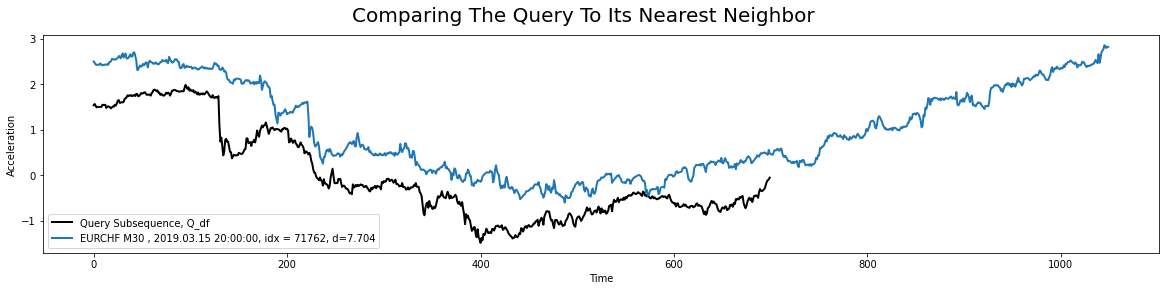

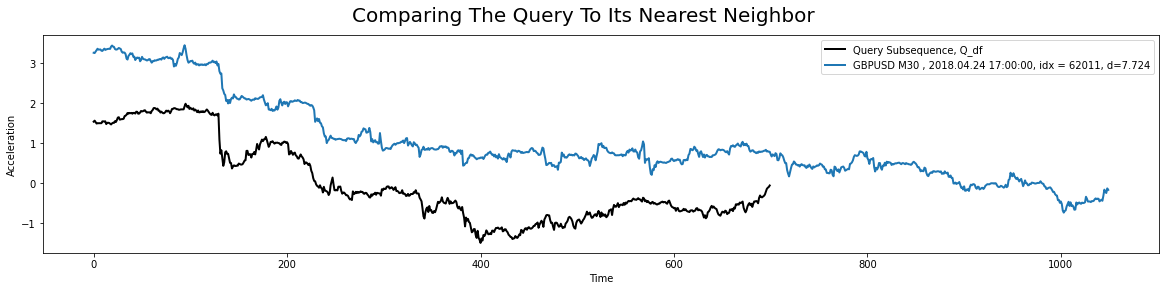

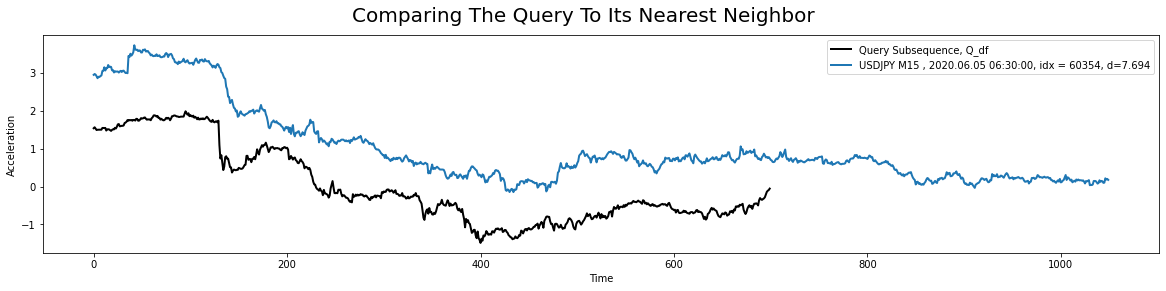

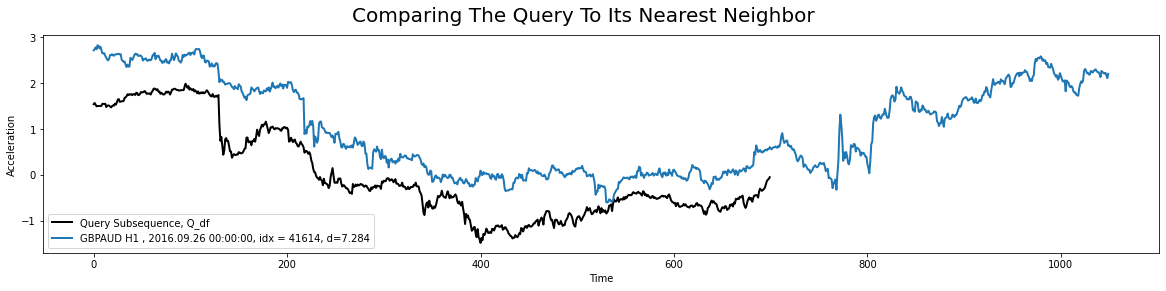

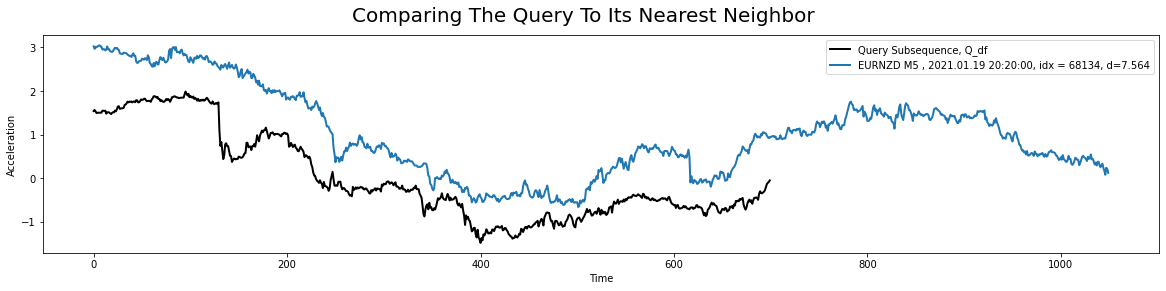

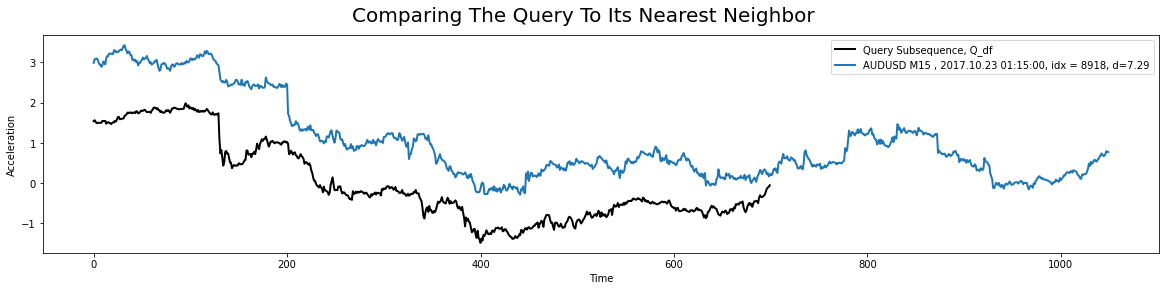

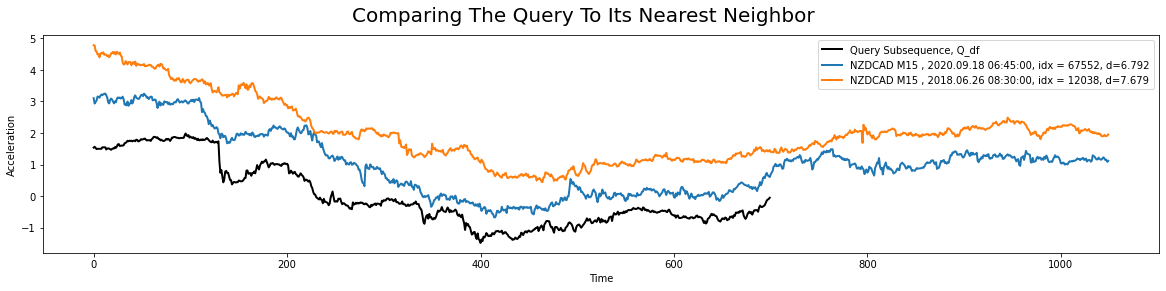

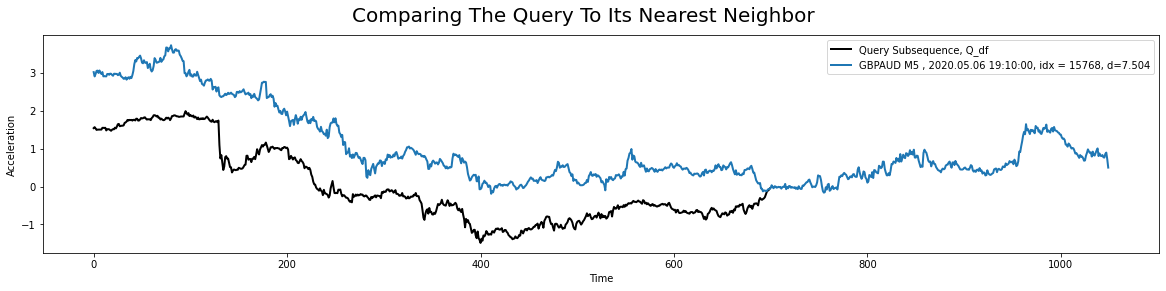

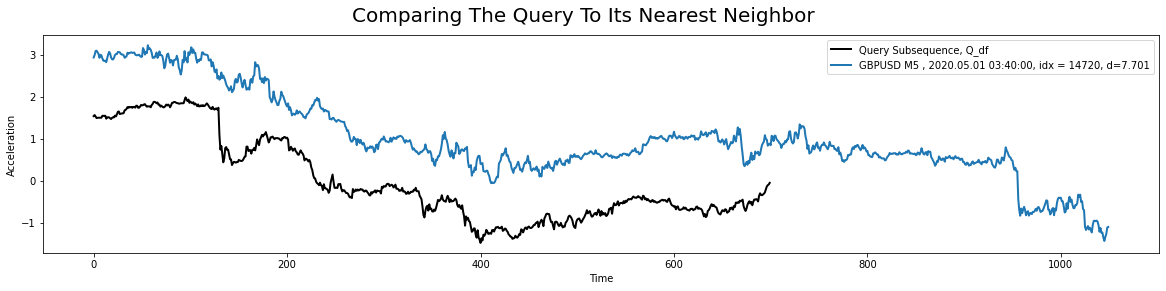

In [419]:
window = 700
start_idx = len(T_df) - window -150
Q_df = T_df.iloc[start_idx:(start_idx+window), :]

for ref in ref_list:
    ref_df = pd.read_csv(ref , sep='\t' )
    ref_name = " ".join(ref.split('/')[-1].split('_')[:2] )
    #ref_df = combine_features(ref_df, col_to_plot)
    distance_profile = compute_distance_profile(Q_df, ref_df, col_name, False) ;
    # This simply returns the (sorted) positional indices of the top 16 smallest distances found in the distance_profile
    k = 80
    idxs = np.argpartition(distance_profile, k)[:k]
    idxs = idxs[np.argsort(distance_profile[idxs])]
    idxs = get_blocks(idxs, 0.5*window)
    idxs = [i for i in idxs if distance_profile[i] < 7.8] # selecting the 5 most similar 
    if idxs:
        compare_query_NN(Q_df, ref_df, col_name, idxs, y_offset=1, future_horizon=1.5, ref_name=ref_name) 

In [435]:
column = 'combined'
distance_profile = stumpy.core.mass(Q_df[column], ref_df[column] )
distance_profile

array([24.4431115 , 24.31965195, 24.36741817, ..., 64.73606571,
       64.6803068 , 64.74061197])

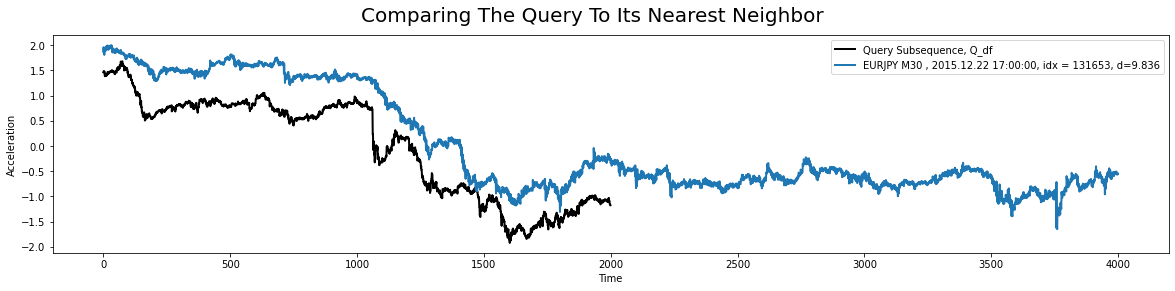

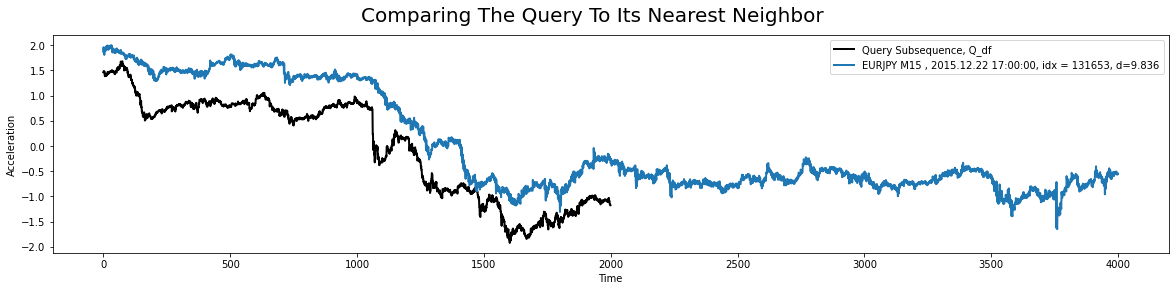

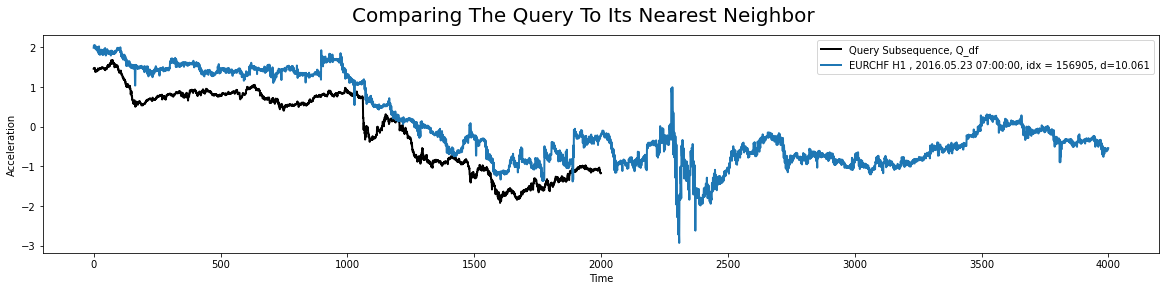

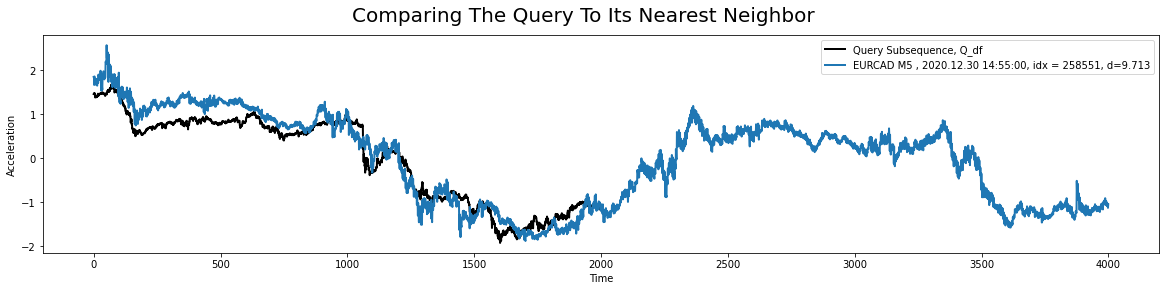

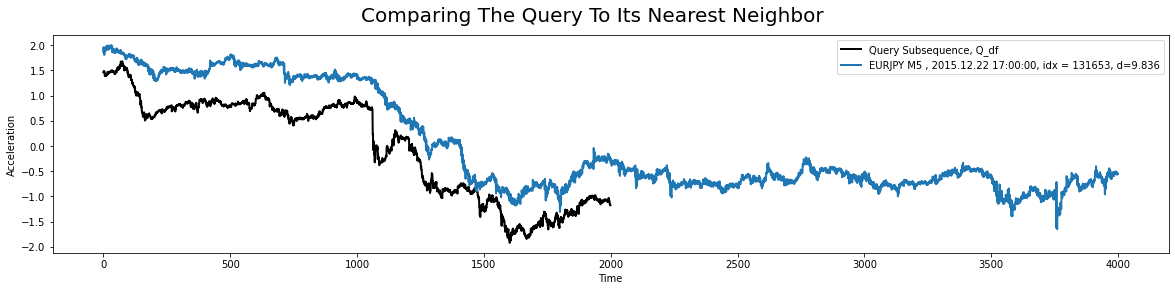

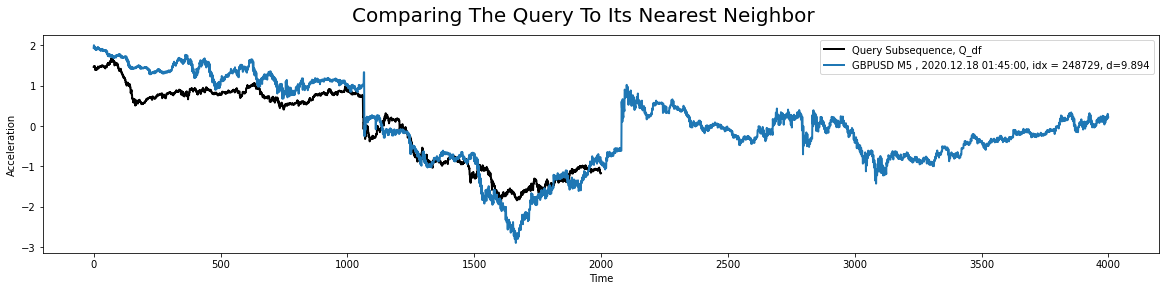

In [442]:
def combine_features(df, columns):
  """ 
  given a dataframe and a list of columns, returns a new dataframe where the
  values in those columns get stacked into a single column named "combined".
  """
  df.dropna(inplace = True)
  newdf = pd.DataFrame(np.repeat(df.values, len(columns),axis=0))
  newdf.columns = df.columns
  newdf['combined'] = df[columns].stack().to_frame()[0].values
  return newdf


col_to_combine = ['<OPEN>', '<LOW>', '<HIGH>', '<CLOSE>']

window = 1000
start_idx = len(T_df) - window -250
Q_df = T_df.copy().iloc[start_idx:(start_idx+window), :]
Q_df = combine_features(Q_df, col_to_plot)
col_name = 'combined'

for ref in ref_list:
    ref_df = pd.read_csv(ref , sep='\t' )
    ref_name = " ".join(ref.split('/')[-1].split('_')[:2] )
    ref_df = combine_features(ref_df, col_to_combine)
    distance_profile = compute_distance_profile(Q_df, ref_df, col_name, False) ;
    # This simply returns the (sorted) positional indices of the top 16 smallest distances found in the distance_profile
    k = 80
    idxs = np.argpartition(distance_profile, k)[:k]
    idxs = idxs[np.argsort(distance_profile[idxs])]
    idxs = get_blocks(idxs, 0.5*window)
    idxs = [i for i in idxs if distance_profile[i] < 10.4] # selecting the 5 most similar 
    if idxs:
        compare_query_NN(Q_df, ref_df, col_name, idxs, y_offset=0, future_horizon=2, ref_name=ref_name) 


To take this a step further, instead of extracting the only top nearest neighbor, we can look at where the top `k = 16` nearest neighbors are located:

In [165]:
# This simply returns the (sorted) positional indices of the top 16 smallest distances found in the distance_profile
k = 16
idxs = np.argpartition(distance_profile, k)[:k]
idxs = idxs[np.argsort(distance_profile[idxs])]
idxs

array([26914, 26912, 26915, 26913, 26910, 26911, 26909, 26916, 26917,
       26919, 26918, 26920, 26908, 26921, 26907, 26922])

And then let's plot all of these subsequences based on their index locations:

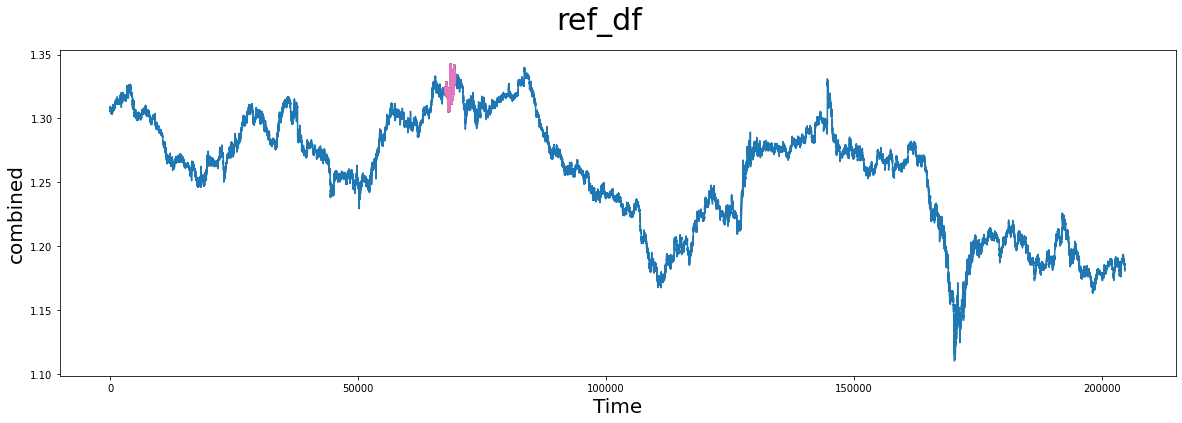

In [84]:
plt.suptitle('ref_df', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel(col_name, fontsize='20')
plt.plot(ref_df[col_name])
#plt.text(2000, 4.5, 'Cement', color="black", fontsize=20)
#plt.text(10000, 4.5, 'Cement', color="black", fontsize=20)
ax = plt.gca()
#rect = Rectangle((5000, -4), 3000, 10, facecolor='lightgrey')
#ax.add_patch(rect)
#plt.text(6000, 4.5, 'Carpet', color="black", fontsize=20)
#plt.plot(range(start_idx, start_idx+len(Q_df)), Q_df[col_name].values, lw=2, label="Original Subsequence")

for idx in idxs:
    plt.plot(range(idx, idx+len(Q_df)), ref_df[col_name].values[idx:idx+len(Q_df)], lw=2)
plt.show()

Unsurprisingly, the top `k = 16` nearest neighbors to `Q_df` (or best matches, shown in multiple colors above) can all be found!

## Summary

And that's it! You have now taken a known pattern of interest (or query), ran it through `core.mass` using STUMPY, and you were able to quickly search for this pattern in another time series. With this newfound knowledge, you can now go and search for patterns in your own time series projects. Happy coding!

## Additional Note - Distance Profiles with Non-normalized Euclidean Distances

There are times when you may want to use non-normalized Euclidean distance as your measure of similarity/dissimilarity, and so, instead of using `core.mass` (which z-normalizes your subsequences first before computing the pairwise Euclidean distances), you can use the `core.mass_absolute` function. This is provided for those who are interested in computing the non-normalized matrix profiles that are available in the complementary `stumpy.aamp`, `stumpy.aamped`, `stumpy.gpu_aamp`, and `stumpy.ammpi` functions.


## Resources

[The Fastest Similarity Search Algorithm for Time Series Subsequences Under Euclidean Distance](http://www.cs.unm.edu/~mueen/FastestSimilaritySearch.html)


[STUMPY Documentation](https://stumpy.readthedocs.io/en/latest/)

[STUMPY Matrix Profile Github Code Repository](https://github.com/TDAmeritrade/stumpy)